In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.signal import resample
from librosa.display import specshow
import os
#import benchmark
import utils
import pandas as pd

In [2]:
#getting all the saxophone wav audios files in an list : audio_files
type_wanted = "bassoon.wav"
directory = r"C:\Users\hippo\OneDrive\Bureau\MINES\2A\T2_Data_Sophia\PROJET\Bach10_v1.1"
audio_filespath =[]
audio_files_tuple = []
for root, dirs, files in os.walk(directory):
    for filename in files:
        #print(os.path.join(root, filename))
        if filename[len(filename)-len(type_wanted):len(filename)] == type_wanted :
            pathfile = os.path.join(root, filename)
            audio_filespath.append(pathfile)
            audio_files_tuple.append(wavfile.read(pathfile))

In [3]:
sample_rate = audio_files_tuple[0][0]
print(sample_rate)
new_sample_rate = 32000


44100


In [4]:
audio_files = []
list_audio = []
for i in range(len(audio_files_tuple)):
    audio_files.append([audio_files_tuple[i][0], audio_files_tuple[i][1].astype(dtype = np.float64)])
    list_audio.append(resample(audio_files[i][1], int(len(audio_files[i][1])*new_sample_rate/audio_files[i][0]), window= "hamming", domain = "time"))

audio_1 = audio_files[0][1]


In [5]:
#Resampling du signal : 
audio_1 = resample(audio_1, int(len(audio_1)*new_sample_rate/sample_rate), window= "hamming", domain = "time")
audio_1 = audio_1

In [6]:
temps_paquet = 0.02#0 #20ms
taille_paquet = int(temps_paquet *new_sample_rate) #nb_echantillons par paquet
print(taille_paquet)
num_paquet_choisi = 100
pos_sample = num_paquet_choisi*taille_paquet
paquet = audio_1[pos_sample:pos_sample + taille_paquet].copy()
np.dtype(paquet[0])

640


dtype('float64')

In [7]:
pos_loss = utils.los_generation(len(audio_1), taille_paquet, 100)
print(len(pos_loss), pos_loss)

90 [ 33623  34483  43412  66392  74083  78195  81080  82383  91023 117029
 121385 145045 149918 151311 159461 169652 176211 185777 190135 210073
 217749 225560 232030 235562 236536 241159 245627 250572 261458 272629
 274578 295018 317642 333625 335754 341332 346376 348476 357345 385273
 389273 399210 409572 414142 415836 417968 435353 453549 466690 470448
 471385 479123 489443 522082 530698 534080 552894 558532 572714 576190
 579672 592054 594321 595062 602618 603570 607678 639971 641100 643053
 660050 673743 698743 701457 710827 722335 723153 732634 734383 738402
 749422 757440 762568 766606 771150 786596 789774 790839 793317 796886]


In [8]:
#préparation des datas : 
def data_prep(list_audio_files, n_audio, taille_paquet, instr = 'Saxphone', prop_train_test = 0.8):
    n_files = len(list_audio_files)
    n_train = int(n_files*prop_train_test)-1
    dir_path = f"Dataset_{instr}"
    #dir_path = os.path.join(os.path.dirname(os.path.realpath(__file__)),dirname)
    train_file_list = []
    test_file_list = []
    if not os.path.isdir(dir_path): 
        os.mkdir(dir_path)
    
    for i in range(n_files) : 
        song = list_audio_files[i]
        pos_gap = utils.los_generation(len(song), taille_paquet, 110)
        for j in range(len(pos_gap)):
            if i <= n_train :
                audio = song[pos_gap[j]- n_audio: pos_gap[j]]
                label = song[pos_gap[j]: pos_gap[j] + taille_paquet]
                #label = np.pad(label, (0, taille_paquet))
                name = f"Train_paquet{i}_{j}.wav"
                name_label = f"Train_label{i}_{j}.wav"
                path = os.path.join(dir_path,name)
                path_label = os.path.join(dir_path,name_label)
                train_file_list.append(
                {'input_audio': path, 'label_audio': path_label}
                )
                #dir_path = os.path.dirname(os.path.realpath(__file__))
            if i > n_train : 
                audio = song[pos_gap[j]- n_audio: pos_gap[j]]
                label = song[pos_gap[j]: pos_gap[j] + taille_paquet]
                #label = np.pad(label, (0, taille_paquet))
                name = f"Test_paquet{i}_{j}.wav"
                name_label = f"Test_label{i}_{j}.wav"
                name_label = f"Test_paquet{i}_{j}.wav"
                path = os.path.join(dir_path,name)
                path_label = os.path.join(dir_path,name_label)
                test_file_list.append(
                {'input_audio': path, 'label_audio': path_label}
                )
            
            wavfile.write(path, new_sample_rate, audio)
            wavfile.write(path_label, new_sample_rate, label)
    return train_file_list, test_file_list



In [9]:
train_file_list, test_file_list = data_prep(list_audio, 2*taille_paquet, taille_paquet)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio


In [11]:
class Audio_Loss(Dataset):
    def __init__(self, file_paths, transform1=None, transform2 = None, transform3 = None, transform4 = None):
        self.file_paths = file_paths
        self.transform1 = transform1
        self.transform2 = transform2
        self.transform3 = transform3
        self.transform4 = transform4

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        # Load input audio file
        input_waveform, input_sr = torchaudio.load(self.file_paths[index]['input_audio'])

        # Load label audio file
        label_waveform, label_sr = torchaudio.load(self.file_paths[index]['label_audio'])
        
        # Apply any necessary transformations
        if self.transform1:
            input_waveform = self.transform1(input_waveform)
            label_waveform = self.transform1(label_waveform)
   
        if self.transform2:
            input_waveform = self.transform2(input_waveform)
            label_waveform = self.transform2(label_waveform)

        return input_waveform[0], label_waveform[0]


In [12]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        previous_audio, label = sample['input_audio'], sample['label_audio']

        return {'previous_audio': torch.from_numpy(previous_audio),
                'label': torch.from_numpy(label)}

In [13]:
directory = r"C:\Users\hippo\OneDrive\Bureau\MINES\2A\T2_Data_Sophia\PROJET\Data-Sophia-\Dataset_Saxphone"
prop_train_test = 0.8
n_files = len(audio_files)
n_train = int(n_files*prop_train_test)-1


In [14]:
print(len(train_file_list))

813


In [15]:
audio_train_dataset = Audio_Loss( 
                           train_file_list
                           )
audio_test_dataset = Audio_Loss( 
                           test_file_list
                           )

In [16]:
def plot_audio(previous_audio, label) : 
    
    t_1 = np.linspace(0,2*temps_paquet,len(previous_audio))
    t_2 = np.linspace(2*temps_paquet,4*temps_paquet,len(label))
    plt.plot(t_1, previous_audio, 'b--')
    plt.plot(t_2, label, 'r--')
    plt.pause(0.001)

0 torch.Size([1280]) torch.Size([640])
1 torch.Size([1280]) torch.Size([640])
2 torch.Size([1280]) torch.Size([640])
3 torch.Size([1280]) torch.Size([640])


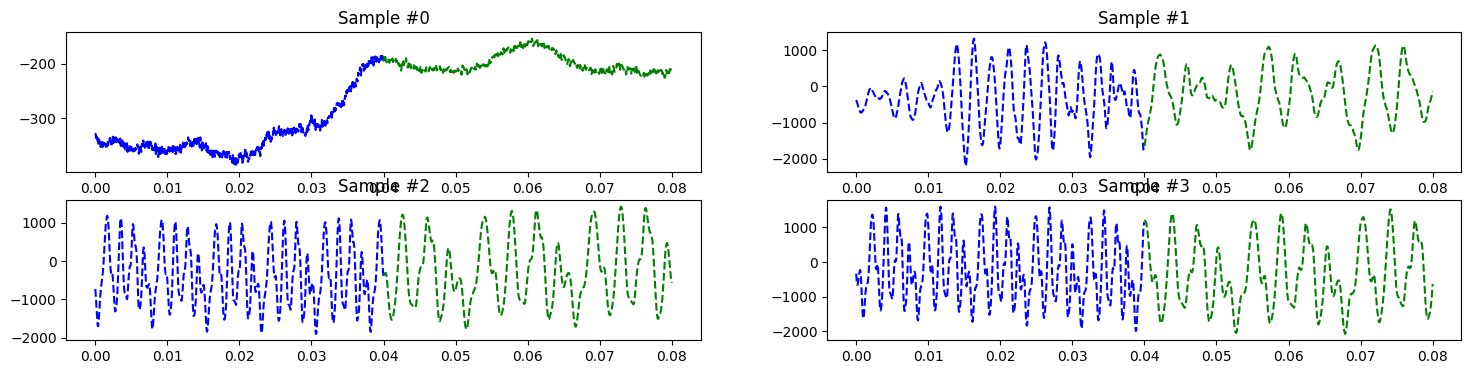

In [17]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(18,4))
ax = axes.flatten()
for i, audio in enumerate(audio_train_dataset):
    print(i, audio[0].shape, audio[1].shape)

    #plt.tight_layout()
    ax[i].set_title('Sample #{}'.format(i))
    #ax.axis('off')
    previous_audio, label = audio[0], audio[1]
    t_1 = np.linspace(0,2*temps_paquet,len(previous_audio))
    t_2 = np.linspace(2*temps_paquet,4*temps_paquet,len(label))
    ax[i].plot(t_1, previous_audio, 'b--')
    ax[i].plot(t_2, label, 'g--')

    if i == 3:
        plt.show()
        break

In [18]:
# problème : dans un même batch les audios sont liés
train_loader = DataLoader(audio_train_dataset, batch_size=6,
                        shuffle=False, num_workers=0)
test_loader = DataLoader(audio_test_dataset, batch_size = 6, 
                         shuffle = False, num_workers=0)

In [19]:
def batch_audio_plot(sample_batched) : 
    previous_audio_batched, label_batched = sample_batched[0], sample_batched[1]
    batch_size = len(previous_audio_batched)
    #im_size = images_batch.size(2)

    #plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        t_1 = np.linspace(0, 2*temps_paquet, len(previous_audio_batched[i,:]))
        t_2 = np.linspace(2*temps_paquet, 3*temps_paquet, len(label_batched[i,:]))
        plt.subplot(1,batch_size, i+1)
        plt.plot(t_1, previous_audio_batched[i,:])
        plt.subplot(1, batch_size, i+1)
        plt.plot(t_2, label_batched[i,:])
        plt.title('Batch from dataloader')

0 torch.Size([6, 1280]) torch.Size([6, 640])
1 torch.Size([6, 1280]) torch.Size([6, 640])
2 torch.Size([6, 1280]) torch.Size([6, 640])
3 torch.Size([6, 1280]) torch.Size([6, 640])
4 torch.Size([6, 1280]) torch.Size([6, 640])
5 torch.Size([6, 1280]) torch.Size([6, 640])
6 torch.Size([6, 1280]) torch.Size([6, 640])
7 torch.Size([6, 1280]) torch.Size([6, 640])
8 torch.Size([6, 1280]) torch.Size([6, 640])
9 torch.Size([6, 1280]) torch.Size([6, 640])
10 torch.Size([6, 1280]) torch.Size([6, 640])


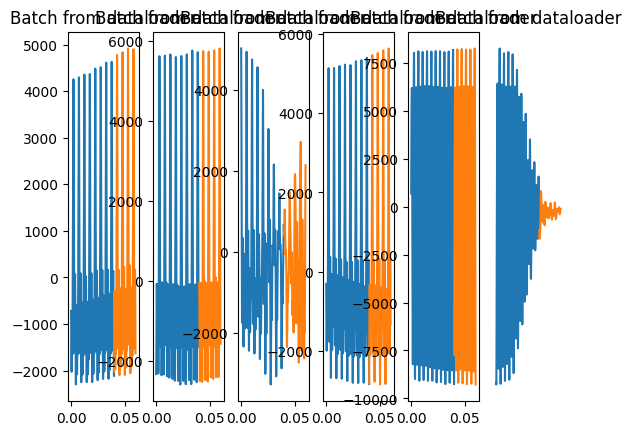

In [20]:
if __name__ == '__main__':
    for i_batch, sample_batched in enumerate(train_loader):
        print(i_batch, sample_batched[0].size(),
            sample_batched[1].size())
        # observe 4th batch and stop.
        if i_batch == 10:
            plt.figure()
            batch_audio_plot(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [22]:
import model
from data_loader import load_data
from training import run as run_training
import utils

ModuleNotFoundError: No module named 'model'

In [ ]:
audio1 = audio_files[0][1]


In [ ]:
#EXAMPLE FILE
def load_config(verbose=False, random=True):
    # load specified settings

    #### Data settings ####
    data_config = {
        "type": 'AR',
        "ar_val": 256,
        "pad_to": 300,  # set to >ar_val for sparse AR estimation
        "ar_params": None,  # for randomly generated AR params
        "noise_std": 1.0,
        "test": 0.2,
        "n_samples": int(1.25e5),  # for 1e5 train size
    }

    # OR manually define AR params:
    if not random:
        # data_config["ar_params"] = [0.2, 0.3, -0.5]
        # Alternative: sparse AR params:
        data_config["ar_params"] = [0.2, 0, 0.3, 0, 0, 0, 0, 0, 0, -0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

        # correct settings if manually set
        data_config["ar_val"] = sum(np.array(data_config["ar_params"]) != 0.0)
        data_config["pad_to"] = int(len(data_config["ar_params"]))

    #### Model settings ####
    model_config = {
        "ar": data_config["ar_val"],  # for normal AR
        "ma": 0,
        "num_layers": 1,
        "d_hidden": None
    }
    if data_config["pad_to"] is not None and data_config["pad_to"] > data_config["ar_val"]:
        model_config["ar"] = data_config["pad_to"]  # for sparse AR

    #### Train settings ####
    train_config = {
        "lr": 2e-4,
        "lr_decay": 0.9,
        "epochs": 10,
        "batch": 128,
        "est_sparsity": 1,  # 0 = fully sparse, 1 = not sparse
        "lambda_delay": 10,  # delays start of regularization by lambda_delay epochs
    }
    # For auto-regularization based on sparsity estimation:
    if data_config["pad_to"] is not None and data_config["pad_to"] > data_config["ar_val"]:
        train_config["est_sparsity"] = data_config["ar_val"] / (1.0 * data_config["pad_to"])

    # Note: find the right learning rate range with a learning rate range test
    # e.g. a LR range test on random AR data (with 5e5 data, batch 64, pad_to 100) led to
    # --->  min 5e-7, max 5e-4

    if verbose:
        print("data_config\n", data_config)
        print("model_config\n", model_config)
        print("train_config\n", train_config)

    return data_config, model_config, train_config


def main(verbose=False, plot=False, save=False, random_ar_param=True):
    # load configuration dicts. Could be implemented to load from JSON instead.
    data_config, model_config, train_config = load_config(verbose, random_ar_param)
    # loads randomly generated data. Could be implemented to load a specific dataset instead.
    data = load_data(audio_train_dataset, verbose, plot) #data_config, verbose, plot)
    # runs training and testing.
    results_dar, stats_dar = run_training(data, model_config, train_config, verbose)

    # optional printing
    if verbose:
        print(stats_dar)

    # optional plotting
    if plot:
        utils.plot_loss_curve(
            losses=results_dar["losses"],
            test_loss=results_dar["test_mse"],
            epoch_losses=results_dar["epoch_losses"],
            show=False,
            save=save
        )
        utils.plot_weights(
            model_config["ar"],
            results_dar["weights"],
            data["ar"],
            model_name="AR-Net",
            save=save
        )
        utils.plot_results(
            results_dar,
            model_name="AR-Net",
            save=save
        )


if __name__ == "__main__":
    main(verbose=True, plot=True, save=True, random_ar_param=False)

data_config
 {'type': 'AR', 'ar_val': 3, 'pad_to': 20, 'ar_params': [0.2, 0, 0.3, 0, 0, 0, 0, 0, 0, -0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'noise_std': 1.0, 'test': 0.2, 'n_samples': 125000}
model_config
 {'ar': 20, 'ma': 0, 'num_layers': 1, 'd_hidden': None}
train_config
 {'lr': 0.0002, 'lr_decay': 0.9, 'epochs': 10, 'batch': 128, 'est_sparsity': 0.15, 'lambda_delay': 10}


NameError: name 'audio_train_dataset' is not defined

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


AttributeError: 'DataLoader' object has no attribute 'multi_target'

In [ ]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2*taille_paquet, 1024),
            nn.ReLU(),
            nn.Linear(1024, 640),
            nn.ReLU(),
            nn.Linear(640, taille_paquet),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1280, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=640, bias=True)
    (3): ReLU()
    (4): Linear(in_features=640, out_features=640, bias=True)
  )
)


In [ ]:
train = model(dataloader)


AttributeError: 'DataLoader' object has no attribute 'flatten'